In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
## Import neccessary packages
import pandas as pd
from csv import reader
import numpy as np
import seaborn as sns
import re

from dateutil import parser

import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('Dev_Scrapping_track - Official.csv')
df = df.reset_index()
df['index'] = df['index'].apply(lambda x: str(x))
df['id'] = df['portal'] + df['index']

In [9]:
df_final = df[['id']]

<Axes: >

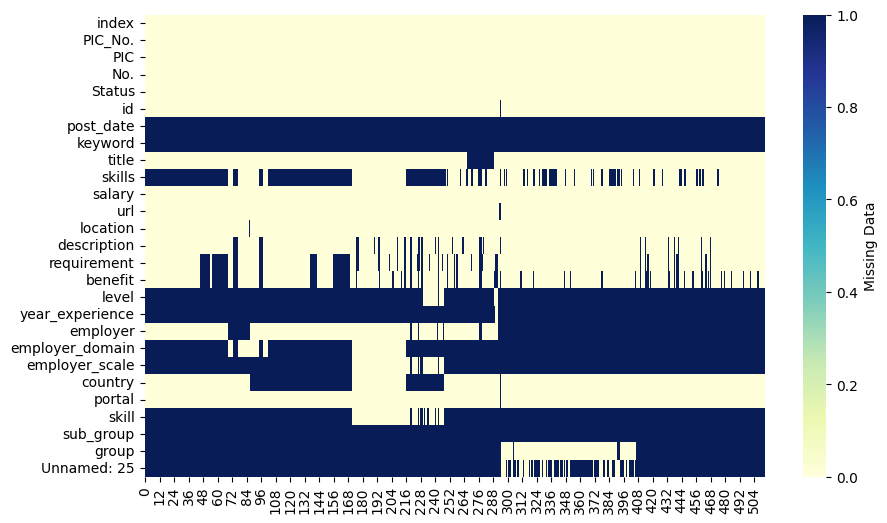

In [10]:
## Variable name in y axis
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

# 1/ Salary
#### Current issues Remove 202 (upboud 700tr), some posts have floating salary such as 47.5 and some posts have wrong unit such as 1000-2000 vnđ


In [11]:
def to_float(row):
  """ Convert data to float """
  if ',' in row:
       row = str(row).replace(',','.')
  if '.' in row:
      if len(re.findall("0", str(row).split('.')[1])) < 1:
        row = float(row)
      elif len(re.findall("0", str(row).split('.')[1])) >= 1:
        row = str(row).replace('.','')
        row = float(row)
  else: row = float(row)
  return row

In [12]:
def replace_all(text, dic):
    """
    This function replace words in key by their values in the dictionary
    text: sentence to translate
    dic: dictionary of keywords need to be replaced and their replaced words
    """
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

In [13]:
def consistent(row,dic_to_change):
  """
  This function remove convert rows have any kind of"upto" word into "value - u"
  """
  ## Keyword to replace accordingly

  if ("from" in row) and ("-" not in row):
    row = replace_all(row, dic_to_change) + " - 9999999999"
    return row

  else:
    row = replace_all(row, dic_to_change)

  return row

In [14]:
def unit(row):
  """
  THis function is to detach sympol or word that describe the currency of money mentioned in the post
  """
  if ("usd" in row) or ("$" in row):
   unit =  "USD"
   return unit
  elif ("vnd" in row) or ("million" in row) or ("mil" in row) or ("milil" in row) or ("tr" in row) or ("vnđ" in row):
   unit = "VND"
   return unit
  elif ("idr" in row):
   unit = "IDR"
  elif ("sgd" in row):
   unit = "SGD"
  else: unit = "Not defined"

  return unit

In [15]:
def detach(row):
  """
  This function is to split 2 values in a range into 2 seperated values
  """
  try:
    if "–" in row:
      min,max = row.split("–")
      min = min.strip()
      max = max.strip()
    else:
      min,max = row.split("-")
      min = min.strip()
      max = max.strip()
  except:
    min = 0
    max = 9999999999
  return [min,max]

In [16]:
def add_unit(datatset,unit_col,count_col,i):
  """
  Thí function is to add automatically unit for posts do not mention currency unit by counting number of 0 in salary
  """
  if (datatset[unit_col][i] != "Not defined"):
    datatset[unit_col][i] = datatset[unit_col][i]
  elif (datatset[unit_col][i] == "Not defined") and (datatset[count_col][i].count("0") >= 12):
    datatset[unit_col][i] = "VND"
  elif (datatset[unit_col][i] == "Not defined") and ("9999999999" in (datatset[count_col][i])) and (datatset[count_col][i].count("0") >= 6):
    datatset[unit_col][i] = "VND"
  else: datatset[unit_col][i] = "USD"
  return datatset[unit_col][i]

In [17]:
def split_group(dataset,col,_index):
    """
    This function is to rearrange group of salary
    Vinh's idea
    Group 1: < 1000
    Group 2: 1000-1500
    Group 3: 1501-2000
    Group 4: 2001-2500
    Group 5: 2501-3000
    Group 6: > 3000
    """
    try:
      result = np.where(dataset[col][_index] <= 1000, "0-1000",
          np.where((dataset[col][_index] > 1000) and (dataset[col][_index] <= 1500), "1001-1500",
              np.where((dataset[col][_index] > 1500) and (dataset[col][_index] <= 2000), "1501-2000",
                  np.where((dataset[col][_index] > 2000) and (dataset[col][_index] <= 2500), "2001-2500",
                           np.where((dataset[col][_index] > 2500) and (dataset[col][_index] <= 3000), "2501-3000",">3000")))))
    except:
      result = "Cant split due to string"
    return result

In [18]:
## Extract neccessary columns from the original dataset
sal_df = df[["id","salary"]]

In [19]:
sal_df['salary'] = sal_df['salary'].fillna("no_data")
sal_df['salary_lower'] = np.NaN
for i in range(len(sal_df)):
  try:
      if ' 0 vnđ' in sal_df['salary'][i].lower():
          sal_df['salary_lower'][i] = sal_df['salary'][i].lower().replace(" 0 vnđ",'')
      else:
          sal_df['salary_lower'][i] = sal_df['salary'][i].lower()
  except:
       sal_df['salary_lower'][i] = "int"

sal_df[sal_df['salary_lower'] == 'int']

Empty DataFrame
Columns: [id, salary, salary_lower]
Index: []

In [20]:
def m_to_million(the_word):
    new_word = the_word
    removed = re.findall("\d+m", new_word)
    for item in removed:
        detached = re.split("",item)
        if 'm' in detached:
            new_word = new_word.replace("m", " million").strip()
    return new_word

def mil_to_million(the_word):
    new_word = the_word
    removed = re.findall("\d+mil", new_word)
    removing_list = []
    if (len(removed) > 0):
        for item in removed:
            detached = re.split("",item)
            detached = list(map(lambda x: x.replace('m',""), detached))
            detached = list(map(lambda x: x.replace('i',""), detached))
            detached = list(map(lambda x: x.replace('l'," million"), detached))
            complete_sal = "".join(detached)
            removing_list.append(complete_sal)
        final_word = " - ".join(removing_list)
        return final_word
    return new_word

def tr_to_million(the_word):
    new_word = the_word
    removed = re.findall("\d+tr", new_word)
    removing_list = []
    if len(removed) > 0:
        for item in removed:
            detached = re.split("",item)
            detached = list(map(lambda x: x.replace('t',""), detached))
            detached = list(map(lambda x: x.replace('r'," million"), detached))
            complete_sal = "".join(detached)
            removing_list.append(complete_sal)
        final_word = " - ".join(removing_list)
        return final_word
    return new_word

def duoi_to_upto(the_word):
    new_word = the_word
    removed = re.findall("dưới+\d", new_word)
    if len(removed) > 0:
        new_word = new_word.replace('dưới',"upto ")
    return new_word

def within_parentheses_remove(title):
    new_title = title
    removed = re.findall("(\(.*?\))", new_title)
    for each in removed:
        new_title = new_title.replace(each, " ").strip()
    return new_title

In [21]:
sal_df['salary_lower'] = sal_df['salary_lower'].apply(lambda x: within_parentheses_remove(x))
sal_df['salary_lower'] = sal_df['salary_lower'].apply(lambda x: mil_to_million(x))
sal_df['salary_lower'] = sal_df['salary_lower'].apply(lambda x: m_to_million(x))
sal_df['salary_lower'] = sal_df['salary_lower'].apply(lambda x: tr_to_million(x))
sal_df['salary_lower'] = sal_df['salary_lower'].apply(lambda x: duoi_to_upto(x))

In [22]:
# tokenize function
def tokenize(title):
    word_list = re.split(r' ', title)
    return word_list
sal_df['tokens']  = sal_df['salary_lower'].apply(lambda x: tokenize(x))

In [23]:
# For Vinh: priority 2nd
mil_list = ["m","mil","millions","triệu","tr","milionlion"]
upto_list = ["dưới","tới","up","upto",'lên']
from_list = ["from","min","từ","trên","trở","fro"]
useless_token = ["bonus","data","gross","hoặc","lên","month","negotiation","net","no","salary","start","thỏa","thuận","year",'~','+',"++","lương:"]

In [24]:
# add column of job group
def synonym_word(title):
    title_tokens = title.split(" ")
    group_defined = []
    for a_token in title_tokens:
        if a_token in mil_list:
            group_defined.append("million")
        elif a_token in upto_list:
            group_defined.append("upto")
        elif a_token in from_list:
            group_defined.append("from")
        elif (a_token == 'đến'):
          if (title_tokens.index('đến') == 0):
            group_defined.append("upto")
          elif (title_tokens.index('đến') == 2):
            group_defined.append("")
          else:
            group_defined.append("-")
        elif a_token in useless_token:
            group_defined.append("")
        else: group_defined.append(a_token)
    return group_defined
sal_df['tokens_cleaned'] = sal_df['salary_lower'].apply(lambda x: synonym_word(x.lower()))
sal_df['salary_cleaned'] = sal_df['tokens_cleaned'].apply(lambda x: " ".join(x))

In [25]:
## Step 2: Remove unneccessary symbol word in the salary content (only contains number and its currency units)
dic_to_change = {"upto to": "upto","upto": "0 - ","++": "","to": "-","from":"","+":"","/year":"","~":""}
sal_df['consistent'] = sal_df["salary_cleaned"].apply(lambda row : consistent(row,dic_to_change))
# ## Step 3-a: Extract currency into a new column
sal_df['Unit'] = sal_df["consistent"].apply(lambda row : unit(row))

In [26]:
## Step 3-b: add unit for posts do not have unit beforehand
for i in range(len(sal_df)):
  sal_df["Unit"][i] = add_unit(sal_df,"Unit","salary",i)

In [27]:
## Step 4: Remove Currency unit in salary column
unit_to_remove = {"usd":"","vnd":"",'vnđ':"","$":"","million":"","mil":"","milil":"","idr":"","sgd":"","il":"","lion":"","tr":"","vnđ/ tháng":"","tháng":"","/":""," - 0":""}
sal_df['remove_unit'] = sal_df["consistent"].apply(lambda row : replace_all(row, unit_to_remove))

In [28]:
sal_df['testing'] = np.NaN
for i in range(len(sal_df)):
    if "-" in sal_df['remove_unit'][i] or "–" in sal_df['remove_unit'][i]:
        sal_df['testing'][i] = "pass"
    else: sal_df['testing'][i] = "not pass"

In [29]:
for i in range(len(sal_df)):
    if (sal_df["testing"][i] == "not pass") and (len(sal_df["remove_unit"][i]) >= 5):
        assign_a_hyphen = tokenize(sal_df["remove_unit"].loc[i])[0:2]
        sal_df["remove_unit"].loc[i] = " - ".join(assign_a_hyphen)
    elif (sal_df["testing"][i] == "not pass") and (len(sal_df["remove_unit"][i]) < 5):
        sal_df["remove_unit"][i] = "0 - " +  sal_df["remove_unit"][i]

In [30]:
## Step 5: Detach the range of salary into 2 column
sal_df = pd.concat([sal_df, sal_df.remove_unit.apply(lambda row: pd.Series({'Min':detach(row)[0], 'Max':detach(row)[1]}))], axis=1)
## Convert data to float
sal_df["Min"] = sal_df["Min"].apply(lambda row : to_float(row))
sal_df["Max"] = sal_df["Max"].apply(lambda row : to_float(row))
sal_df[[isinstance(value, str) for value in sal_df['Max']]]['Max']

Series([], Name: Max, dtype: float64)

In [31]:
## Step 5: Detach the range of salary into 2 column
sal_df['Unit_new'] = np.NaN
for i in range(len(sal_df)):
    if (sal_df["Unit"][i] == "USD") and (sal_df["Max"][i] > 50000) and (sal_df["Max"][i] < 9999999999):
       sal_df["Unit_new"][i] = 'VND'
    elif (sal_df["Unit"][i] == "VND") and (sal_df["Max"][i] < 100000) and (sal_df["Max"][i] > 1000):
       sal_df["Unit_new"][i] = 'USD'
    else: sal_df["Unit_new"][i] = sal_df["Unit"][i]

In [32]:
sal_df['Max_new'] = np.NaN
sal_df['Min_new'] = np.NaN

for i in range(len(sal_df)):
    if (sal_df["Unit_new"][i] == "VND") and (sal_df["Max"][i] < 1000000):
       sal_df["Max_new"][i] = sal_df["Max"][i]*1000000
    else: sal_df["Max_new"][i] = sal_df["Max"][i]

for i in range(len(sal_df)):
    if (sal_df["Unit_new"][i] == "VND") and (sal_df["Min"][i] < 1000000):
       sal_df["Min_new"][i] = sal_df["Min"][i]*1000000
    else: sal_df["Min_new"][i] = sal_df["Min"][i]

In [33]:
## Remove outlier
#### if VND is higher than 100.000.000 or lower than 1.000.000, then check
print('Max VND',sorted(list(sal_df[sal_df["Unit"]  == 'VND']['Max_new'].unique())))
print('Min VND',sorted(list(sal_df[sal_df["Unit"]  == 'VND']['Min_new'].unique())))
#### if USD is higher than 20.000 or lower than 100, then check
print('Max USD',sorted(list(sal_df[sal_df["Unit"]  == 'USD']['Max_new'].unique())))
print('Min USD',sorted(list(sal_df[sal_df["Unit"]  == 'USD']['Min_new'].unique())))

sal_df.at[202,'Max_new'] = 70000000
print('Max VND',sorted(list(sal_df[sal_df["Unit"]  == 'VND']['Max_new'].unique())))

Max VND [2000.0, 3000000.0, 6000000.0, 7000000.0, 10000000.0, 11000000.0, 12000000.0, 13000000.0, 14000000.0, 15000000.0, 15400000.0, 16000000.0, 17000000.0, 18000000.0, 20000000.0, 22000000.0, 23000000.0, 25000000.0, 26000000.0, 28600000.0, 30000000.0, 32000000.0, 33000000.0, 35000000.0, 39600000.0, 40000000.0, 44000000.0, 45000000.0, 47000000.0, 47500000.0, 50000000.0, 52000000.0, 55000000.0, 57000000.0, 60000000.0, 70000000.0, 700000000.0, 9999999999.0]
Min VND [0.0, 1000.0, 1000000.0, 2000000.0, 5000000.0, 7000000.0, 7100000.0, 8000000.0, 9000000.0, 10000000.0, 11000000.0, 12000000.0, 13000000.0, 14000000.0, 15000000.0, 16000000.0, 17000000.0, 17600000.0, 18000000.0, 20000000.0, 22000000.0, 24200000.0, 25000000.0, 26400000.0, 30000000.0, 33000000.0, 34000000.0, 35000000.0, 38000000.0, 40000000.0, 44000000.0]
Max USD [300.0, 400.0, 600.0, 700.0, 900.0, 1000.0, 1100.0, 1200.0, 1300.0, 1500.0, 1600.0, 1800.0, 2000.0, 2200.0, 2300.0, 2400.0, 2500.0, 2600.0, 2700.0, 3000.0, 3200.0, 3500

In [34]:
## Step 7: Exchange to USD money with exchange_rate updated to the newest
exchange_rate_VND = 0.000043
exchange_rate_IDR = 0.000067
exchange_rate_SRD = 0.75
sal_df["Min_convert"] = np.NaN
sal_df["Max_convert"] = np.NaN
for i in range(len(sal_df)):
  if (sal_df["Unit_new"][i] == "VND") and (sal_df["Min_new"][i] == 0):
    sal_df["Min_convert"][i] = 0
    sal_df["Max_convert"][i] = sal_df["Max_new"][i]*exchange_rate_VND
  elif (sal_df["Unit_new"][i] == "VND") and (sal_df["Max_new"][i] == 9999999999):
    sal_df["Min_convert"][i] = sal_df["Min_new"][i]*exchange_rate_VND
    sal_df["Max_convert"][i] = 9999999999
  elif (sal_df["Unit_new"][i] == "VND"):
    sal_df["Min_convert"][i] = sal_df["Min_new"][i]*exchange_rate_VND
    sal_df["Max_convert"][i] = sal_df["Max_new"][i]*exchange_rate_VND

  elif (sal_df["Unit_new"][i] == "SGD") and (sal_df["Min_new"][i] == 0):
    sal_df["Min_convert"][i] = 0
    sal_df["Max_convert"][i] = sal_df["Max_new"][i]*exchange_rate_SRD
  elif (sal_df["Unit_new"][i] == "SGD") and (sal_df["Max_new"][i] == 9999999999):
    sal_df["Min_convert"][i] = sal_df["Min_new"][i]*exchange_rate_SRD
    sal_df["Max_convert"][i] = 9999999999
  elif (sal_df["Unit_new"][i] == "SGD"):
    sal_df["Min_convert"][i] = sal_df["Min_new"][i]*exchange_rate_SRD
    sal_df["Max_convert"][i] = sal_df["Max_new"][i]*exchange_rate_SRD

  elif (sal_df["Unit_new"][i] == "IDR") and (sal_df["Min_new"][i] == 0) and (sal_df["Min_new"][i] > 100000):
    sal_df["Min_convert"][i] = 0
    sal_df["Max_convert"][i] = sal_df["Max_new"][i]*exchange_rate_IDR
  elif (sal_df["Unit_new"][i] == "IDR") and (sal_df["Max_new"][i] == 9999999999) and (sal_df["Max_new"][i] > 100000):
    sal_df["Min_convert"][i] = sal_df["Min_new"][i]*exchange_rate_IDR
    sal_df["Max_convert"][i] = 9999999999
  elif (sal_df["Unit_new"][i] == "IDR") and (sal_df["Max_new"][i] > 100000):
    sal_df["Min_convert"][i] = sal_df["Min_new"][i]*exchange_rate_IDR
    sal_df["Max_convert"][i] = sal_df["Max_new"][i]*exchange_rate_IDR

  else:
    sal_df["Min_convert"][i] = sal_df["Min_new"][i]
    sal_df["Max_convert"][i] = sal_df["Max_new"][i]

In [35]:
def second_largest(list):
    large= max(list)
    list.remove(large)
    large= max(list)
    return large

def second_smallest(list):
    small= min(list)
    list.remove(small)
    small= min(list)
    return small

print("Max of upbound",second_largest(list(sal_df["Max_convert"].unique())))
print("Min of upbound",sal_df["Max_convert"].min())
print("Max of lowbound",sal_df["Min_convert"].max())
print("Min of lowbound",second_smallest(list(sal_df["Min_convert"].unique())))

Max of upbound 4800.0
Min of upbound 129.0
Max of lowbound 3000.0
Min of lowbound 43.0


In [36]:
## Step 8-a: Combine 2 minimum and maximum of salary into a new range
sal_df["Min_convert"] = sal_df["Min_convert"].apply(lambda x: str(x))
sal_df["Max_convert"] = sal_df["Max_convert"].apply(lambda x: str(x))
sal_df["salary_convert"] = sal_df["Min_convert"] + " - " + sal_df["Max_convert"]
## Counting number of value in each new group
num_cat = sal_df["salary_convert"].value_counts().to_frame().reset_index()
num_cat.rename(columns={'index': 'Category','salary_convert': 'Counting'},inplace=True)

In [37]:
## Step 8-b: Split into new group bu the avẻange of minimum and maximum
sal_df["Min_convert"] = sal_df["Min_convert"].apply(lambda x: float(x))
sal_df["Max_convert"] = sal_df["Max_convert"].apply(lambda x: float(x))

In [38]:
## Compute the average of minimum and maximum value in order to split into the new groups
sal_df["average"] = np.where(sal_df["Max_convert"] == 9999999999, sal_df["Min_convert"],
                             np.where(sal_df["Min_convert"] == 0, sal_df["Max_convert"], (sal_df["Min_convert"] + sal_df["Max_convert"])/2))
sal_df["standard_deviation"] = np.where(sal_df["Max_convert"] == 9999999999, sal_df["Min_convert"],(sal_df["Min_convert"] + sal_df["Max_convert"])/2 - sal_df["Min_convert"])

In [39]:
## Grouping by precision
sal_df["precision"] = np.where(sal_df["standard_deviation"] == 0, "Very High",
                            np.where((sal_df["standard_deviation"] > 0) & (sal_df["standard_deviation"] <= 100), "High",
                               np.where((sal_df["standard_deviation"] > 100) & (sal_df["standard_deviation"] <= 200), "Medium","Low")))

In [40]:
## Step 9: Loop over to grouping each column into new group
new_group = []
for i in range(len(sal_df)):
  the_new = split_group(sal_df,"average",i)
  new_group.append(the_new)
sal_df["new_group"] = new_group

In [41]:
sal_df['new_group'] = sal_df['new_group'].apply(lambda x: str(x))
sal_count_df = sal_df['new_group'].to_frame().reset_index()

<Axes: xlabel='index', ylabel='new_group'>

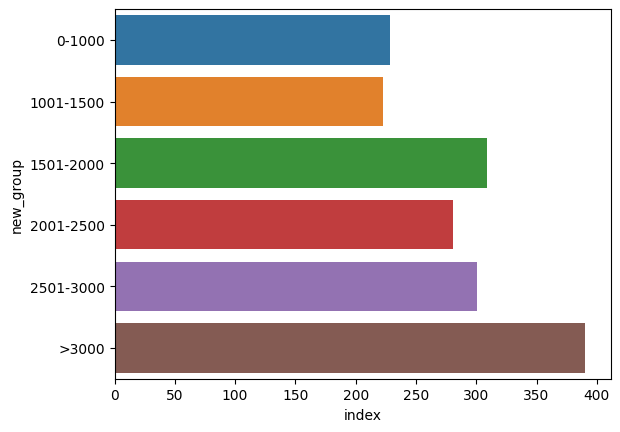

In [42]:
sns.barplot(x='index',y='new_group',data=sal_count_df,
            order = ['0-1000','1001-1500','1501-2000','2001-2500','2501-3000','>3000'],ci=False)

In [43]:
df_final = df_final\
          .merge(sal_df[['id','salary','salary_convert','average', 'standard_deviation', 'precision','new_group']],on='id',how='inner')

# 2/ Skill

In [44]:
skill_df = df.loc[~((df['skill'].isna()) & (df['skills'].isna())),['id','skill','skills']].reset_index()

In [45]:
df[['id','requirement','skill','skills']]

id                                        requirement skill  \
0    timviec3650  Yêu cầu: Tốt nghiệp đại học chuyên ngành có li...   NaN   
1    timviec3651  Yêu cầu: Tốt nghiệp Đại học chuyên ngành CNTT,...   NaN   
2    timviec3652  Yêu cầu: Tốt nghiệp đại học các ngành liên qua...   NaN   
3    timviec3653  Yêu cầu: - Giới tính: Nam (tuổi từ 22-25) - Tố...   NaN   
4    timviec3654  Yêu cầu: - Tốt nghiệp đại học các ngành liên q...   NaN   
..           ...                                                ...   ...   
508    joboko508  ['MS in Computer Science or related fields;', ...   NaN   
509    joboko509  ['MS in Computer Science or related fields;', ...   NaN   
510    joboko510                  ['Business Analyst, Python, SQL']   NaN   
511    joboko511                          ['Python, Database, SQL']   NaN   
512    joboko512                  ['Business Analyst, Python, SQL']   NaN   

                                                skills  
0                                                  NaN  
1                                                  NaN  
2                                                  NaN  
3                                                  NaN  
4                                                  NaN  
..                                                 ...  
508  ;Good at English communicating and reading doc...  
509  Data stacks such as Hadoop, Spark. Understandi...  
510  magician to join our friendly team and fill th...  
511  right for you.We are seeking a new Data Scient...  
512  data, run experiments, create ad-hoc reports, ...  

[513 rows x 4 columns]

In [46]:
skill_df['skill_combined'] = np.where(skill_df['skills'].isna(),skill_df['skill'],
                                      np.where(skill_df['skill'].isna(),skill_df['skills'],
                                               np.where(skill_df['skill'] == skill_df['skills'], skill_df['skill'] ,skill_df['skill']+','+skill_df['skills'])))

In [47]:
# import string
# def num_punct_remove(title):
#   new_title = title.lower()
#   numbers = re.findall("(\d+)", new_title)
#   for n in numbers:
#     new_title = new_title.replace(n, " ").strip()
#   for p in string.punctuation:
#     new_title = new_title.replace(p, " ").strip()
#   return new_title


# skill_df['skill_combined'] = skill_df['skill_combined'].apply(lambda x: num_punct_remove(x))

In [48]:
## Step 1: Translate all contents into english
from deep_translator import GoogleTranslator
_translate = []
for i in range(len(skill_df)):
    try:
      tran = GoogleTranslator(source='auto', target='en').translate(skill_df['skill_combined'][i])
      _translate.append(tran)
    except:
      _translate.append(skill_df['skill_combined'][i])
skill_df['skill_translated'] = _translate

In [49]:
skill_df.skill_translated = skill_df.skill_translated.str.split(',')
skill_df = skill_df.explode('skill_translated')
skill_df.skill_translated = skill_df.skill_translated.str.split('.')
skill_df = skill_df.explode('skill_translated')
skill_df.skill_translated = skill_df.skill_translated.str.split('\n')
skill_df = skill_df.explode('skill_translated')
skill_df.skill_translated = skill_df.skill_translated.str.split('-')
skill_df = skill_df.explode('skill_translated')

In [50]:
skill_df

index              id skill  \
0       69  vietnamworks69   NaN   
0       69  vietnamworks69   NaN   
0       69  vietnamworks69   NaN   
0       69  vietnamworks69   NaN   
1       70  vietnamworks70   NaN   
..     ...             ...   ...   
299    512       joboko512   NaN   
299    512       joboko512   NaN   
299    512       joboko512   NaN   
299    512       joboko512   NaN   
299    512       joboko512   NaN   

                                                skills  \
0    KỸ NĂNG\nBusiness Analyst BA, Business Analysi...   
0    KỸ NĂNG\nBusiness Analyst BA, Business Analysi...   
0    KỸ NĂNG\nBusiness Analyst BA, Business Analysi...   
0    KỸ NĂNG\nBusiness Analyst BA, Business Analysi...   
1    KỸ NĂNG\nBussiness Analyst, T24 Corebanking, T...   
..                                                 ...   
299  data, run experiments, create ad-hoc reports, ...   
299  data, run experiments, create ad-hoc reports, ...   
299  data, run experiments, create ad-hoc reports, ...   
299  data, run experiments, create ad-hoc reports, ...   
299  data, run experiments, create ad-hoc reports, ...   

                                        skill_combined  \
0    KỸ NĂNG\nBusiness Analyst BA, Business Analysi...   
0    KỸ NĂNG\nBusiness Analyst BA, Business Analysi...   
0    KỸ NĂNG\nBusiness Analyst BA, Business Analysi...   
0    KỸ NĂNG\nBusiness Analyst BA, Business Analysi...   
1    KỸ NĂNG\nBussiness Analyst, T24 Corebanking, T...   
..                                                 ...   
299  data, run experiments, create ad-hoc reports, ...   
299  data, run experiments, create ad-hoc reports, ...   
299  data, run experiments, create ad-hoc reports, ...   
299  data, run experiments, create ad-hoc reports, ...   
299  data, run experiments, create ad-hoc reports, ...   

                                      skill_translated  
0                                              KỸ NĂNG  
0                                  Business Analyst BA  
0                                    Business Analysis  
0                                                Azure  
1                                              KỸ NĂNG  
..                                                 ...  
299                                               data  
299                                    run experiments  
299                                          create ad  
299                                        hoc reports  
299   generate proposals to improve operational eff...  

[1345 rows x 6 columns]

Language: english, japanese, korean,
program: sql, python, r, hadoop, spark


In [51]:
class_encoding = {
    'Paid time off': 'F1',
    'Discounts/rewards/bonuses': 'F2',
    'Tuition reimbursement': 'E1',
    'Growth plan': 'E2',
    'Training': 'E3',
    'Insurance': 'W1',
    'Daily wellness': 'W2',
    'Appreciation programs': 'R1',
    'Company parties/trips': 'R2',
    'Flexible schedule': 'R3',
    'Family planning services': 'C1',
    'Child care assistance': 'C2',
    'Working equipment': 'I1',
    'Working place': 'I2'
}

class_dict = pd.DataFrame({'benefit': list(class_encoding.keys()), 'code': list(class_encoding.values()) })
class_dict.loc[class_dict['code'].str.contains("F"), 'benefit_group'] = 'Finance'
class_dict.loc[class_dict['code'].str.contains("E"), 'benefit_group'] = 'Education'
class_dict.loc[class_dict['code'].str.contains("W"), 'benefit_group'] = 'Wellness'
class_dict.loc[class_dict['code'].str.contains("R"), 'benefit_group'] = 'Recognition'
class_dict.loc[class_dict['code'].str.contains("C"), 'benefit_group'] = 'Family Care'
class_dict.loc[class_dict['code'].str.contains("I"), 'benefit_group'] = 'Infrastructure'
class_dict

benefit code   benefit_group
0               Paid time off   F1         Finance
1   Discounts/rewards/bonuses   F2         Finance
2       Tuition reimbursement   E1       Education
3                 Growth plan   E2       Education
4                    Training   E3       Education
5                   Insurance   W1        Wellness
6              Daily wellness   W2        Wellness
7       Appreciation programs   R1     Recognition
8       Company parties/trips   R2     Recognition
9           Flexible schedule   R3     Recognition
10   Family planning services   C1     Family Care
11      Child care assistance   C2     Family Care
12          Working equipment   I1  Infrastructure
13              Working place   I2  Infrastructure

In [52]:
class_label = {class_dict.iloc[i]['code']: [] for i in range(0, len(class_dict))}

def append_label(original_label: dict, appended_label: dict):
    updated_label = original_label

    # append new label
    for k, v in appended_label.items():
        try:
            if type(v) is list:
                updated_label[k] = updated_label[k] + v
            else:
                updated_label[k] = updated_label[k] + [v]
        except:
            print("There is no class called", k)

    # drop duplicates
    for k, v in updated_label.items():
        updated_label[k] = pd.Series(v).unique().tolist()

    return updated_label

In [53]:
label_ver1 = append_label(class_label, {
                'F1': ['holiday', 'leave', 'days off','inpatient',
                       'outpatient','tet','sickness','new year','maternity','wedding'
                       ,'marriage','lucky money','support personal loan','paternity'],

                'F2': ['salary increase', 'bonus', 'discount',
                       'allowance','13th','t14','14 month','15 month','15th','16 month salary','awarded','compensation','reward','award'],

                'E1': ['course','classes','account','library'],

                'E2': ['review', 'growth', 'career', 'promotion','self-determined','advancement','advancement'],

                'E3': ['training', 'learning', 'seminar', 'workshop','trained','development',
                       'personal development','skill development','orientation','improvement',
                       'support self-development','instructor','improve individual skill'],

                'W1': ['insurance','social insurance', 'health check', 'health insurance',
                       'unemployement', 'health care insurance' , 'medical','pvi care','health talk'],

                'W2': ['food', 'beverage', 'coffee', ' tea ', 'snack','entertainment','happy time','club',
                       'game', 'milktea', 'esport','football','lunch','breakfast','badminton','happy time',
                       'fruit','pantry','swimming','yoga','refreshment','happy hour','drink','pingpong','table tennis',
                       'happy meal','basketball','volleyball','gift','wellness','phone bill','phone sim'],

                'R1': ['appreciation', 'recognization','evaluation','assessment'],

                'R2': ['travel', 'trip', 'party', 'birthday','parties','christmas','picnic',
                       'team building', 'team-building', 'teambuilding', "women's day",
                       'retreat', 'tourism','vacation','color fest','festival','yearend',
                       'year anniversary','festival','founding day','event','bonding','welfare'],

                'R3': ['hybrid','flexible time','work home','remote'],

                'C1': ['family',"happy mom's"],

                'C2': ['childbirth celebration','child'],

                'I1': ['equipment', 'device', 'computer', 'laptop','macbook','access','shuttle bus'],

                'I2': ['facility','gym','yoga center','dormitory support','fitness','playground']
                })
label_ver1

{'F1': ['holiday',
  'leave',
  'days off',
  'inpatient',
  'outpatient',
  'tet',
  'sickness',
  'new year',
  'maternity',
  'wedding',
  'marriage',
  'lucky money',
  'support personal loan',
  'paternity'],
 'F2': ['salary increase',
  'bonus',
  'discount',
  'allowance',
  '13th',
  't14',
  '14 month',
  '15 month',
  '15th',
  '16 month salary',
  'awarded',
  'compensation',
  'reward',
  'award'],
 'E1': ['course', 'classes', 'account', 'library'],
 'E2': ['review',
  'growth',
  'career',
  'promotion',
  'self-determined',
  'advancement'],
 'E3': ['training',
  'learning',
  'seminar',
  'workshop',
  'trained',
  'development',
  'personal development',
  'skill development',
  'orientation',
  'improvement',
  'support self-development',
  'instructor',
  'improve individual skill'],
 'W1': ['insurance',
  'social insurance',
  'health check',
  'health insurance',
  'unemployement',
  'health care insurance',
  'medical',
  'pvi care',
  'health talk'],
 'W2': ['food